In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = np.load("/content/drive/MyDrive/train_data.npy")
train_label = np.load("/content/drive/MyDrive/train_label.npy")
test = np.load("/content/drive/MyDrive/test_data.npy")
test_label = np.load("/content/drive/MyDrive/test_label.npy")

<BarContainer object of 10 artists>

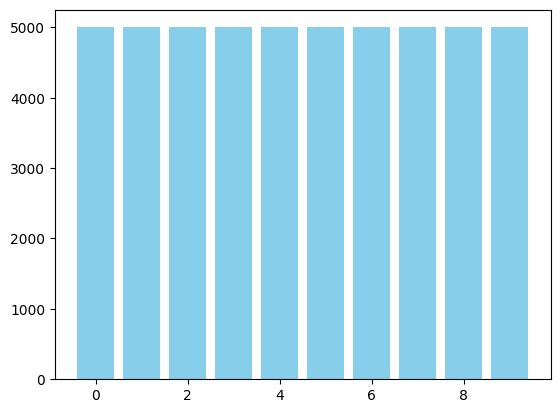

In [4]:
categories, counts = np.unique(train_label, return_counts=True)
plt.bar(categories, counts, color='skyblue')

In [ ]:
train.shape

(50000, 128)

In [5]:
#Define activation class
class Activation(object):
  def __relu(self, x):
    return np.maximum(x, 0)

  def __relu_deriv(self, a):
    # a = relu(x)
    a[a <= 0] = 0
    a[a > 0] = 1
    return a

  def __init__(self, activation = 'relu'):
    self.f = self.__relu
    self.f_deriv = self.__relu_deriv

In [41]:
#Define HiddenLayer
class HiddenLayers(object):
  def __init__(self, n_in, n_out, activation_last_layer = 'relu', activation = 'relu', W = None, b = None, momentum = False, NAG = False, adagrad = False, miniBatch = False, batchNorm = False, dropout = 0.0):
    self.input = None
    self.activation = Activation(activation).f if activation else None


    #Assign init values for weights
    self.W = np.random.uniform(
        low = -np.sqrt(6. / (n_in + n_out)),
        high = np.sqrt(6. / (n_in + n_out)),
        size = (n_in, n_out)
    )

    #Assign init values for bias
    self.b = np.zeros((1, n_out))

    #Assign init values for gradations
    self.grad_w = np.zeros(self.W.shape)
    self.grad_b = np.zeros(self.b.shape)

    #store momentum
    self.momentum = momentum
    self.NAG = NAG
    if self.momentum:
      self.V_w = np.zeros(self.W.shape)
      self.V_b = np.zeros((1, n_out))

    #adagrad
    self.adagrad = adagrad
    if self.adagrad:
      self.lr_w = np.zeros(self.W.shape)
      self.lr_b = np.zeros((1, n_out))
      self.lr_gamma = np.zeros((1, n_out))
      self.lr_beta = np.zeros((1, n_out))

    if batchNorm:
      self.V_gamma = np.zeros((1, n_out))
      self.V_beta = np.zeros((1, n_out))

    #miniBatSize
    self.miniBatch = 1 if not miniBatch else miniBatch

    #batchNorm
    self.batchNorm = batchNorm
    self.running_mean = np.zeros((1, n_out))
    self.running_var = np.zeros((1, n_out))


    #dropout rate
    self.dropout = dropout

    #activation deriv of last layer
    self.activation_deriv = None
    if activation_last_layer:
      self.activation_deriv = Activation(activation_last_layer).f_deriv


    #Assign init values for batch normatlization parameters
    self.epsilon = 1e-15
    self.gamma = np.ones((1, n_out))
    self.beta = np.zeros((1, n_out))
    self.mean = None
    self.var = None
    self.x_hat = None

  #the forward and backward progress for each training epoch
  def forward(self, input, predict):
    '''
    input: np.array
    predict: if true: predict
    '''
    #NAG
    if self.NAG == True:
      self.W = self.W - self.momentum * self.V_w
      if self.batchNorm:
        self.gamma = self.gamma - self.momentum * self.V_gamma
        self.beta = self.beta - self.momentum * self.V_beta


    output = np.dot(input, self.W) + self.b
    self.input = input
    if self.dropout > 0 and not predict:
      self.mask = np.random.rand(*output.shape) > self.dropout
      output = output * self.mask

    elif self.dropout > 0 and predict:
      output = output * (1.0 - self.dropout)

    #Batch Normatlization
    if self.batchNorm and not predict:
      self.mean = np.mean(output, axis = 0, keepdims = True)
      self.var = np.var(output, axis = 0, keepdims = True)
      self.x_hat = (output - self.mean) / np.sqrt(self.var + self.epsilon)
      output = self.gamma * self.x_hat + self.beta

      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
      self.running_var = self.momentum * self.running_var + (1- self.momentum) * self.var

    #Batch predict
    elif self.batchNorm and predict:
      if not self.momentum:
        self.mean = np.mean(output, axis = 0, keepdims = True)
        self.var = np.var(output, axis = 0, keepdims = True)
        output = self.gamma * ((output - self.mean) / np.sqrt(self.var + self.epsilon)) + self.beta
      else:
        output = self.gamma * ((output - self.running_mean) / np.sqrt(self.running_var + self.epsilon)) + self.beta


    self.output = (
        output if self.activation is None
        else self.activation(output)
    )
    return self.output

  def backward(self, delta, output_layer = False):

    if self.batchNorm:
      N = delta.shape[0]
      dx_hat = delta * self.gamma
      dvar = np.sum(dx_hat * (self.output - self.mean) * (-0.5) * (self.var + self.epsilon) ** (-1.5), axis = 0)
      dmean = np.sum(dx_hat * (-1 / np.sqrt(self.var + self.epsilon)), axis = 0) + dvar * np.sum(-2 * (self.output - self.mean), axis = 0) / N
      delta = dx_hat / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.output - self.mean) / N + dmean / N

      self.grad_gamma = np.sum(delta * self.x_hat, axis = 0, keepdims = True)
      self.grad_beta = np.sum(delta, axis = 0, keepdims = True)
      #adagrad
      if self.adagrad:
        self.lr_gamma += self.grad_gamma ** 2
        self.lr_beta += self.grad_beta ** 2

    if self.batchNorm:
      self.grad_b = np.sum(delta, axis = 0, keepdims = True)
    else:
      if self.miniBatch != 1:
        self.grad_b = np.mean(delta, axis = 0, keepdims = True)
      else:
        self.grad_b = delta

    if self.dropout > 0:
      delta = delta * self.mask

    self.grad_w = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) / self.miniBatch
    #adagrad
    if self.adagrad:
      self.lr_w += self.grad_w ** 2
      self.lr_b += self.grad_b ** 2

    if self.activation_deriv:
      delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

    return delta

In [46]:

#MLP
class MLP:
  #last layer is softmax
  def __init__(self, layers, activation = [None, 'relu', None], momentum = False, NAG = False, adagrad = False, miniBatch = False, weightDecay = 0.0, batchNorm = False, dropout = [0.0, 0.0], earlyStopping = False):
    '''
    layers: A list containing the number of units in each layer
    activatoin: the activation function to be used.
    momentum: A float number to determine if use momentum, what's the value of gamma
    NAG: A boolean dicating whether to use NAG or not
    adagrad: A boolean dicating whether to use adagrad or not
    MiniBatch: An int number to determine if use miniBatch, what's the size of batch
    weightDecay: A float number to determine the penalty.
    batchNorm: A boolean indicating whether to use batch norm or not
    dropout: A list contains float number between 0 to 1 to determine the proportion of dropout
    earlyStopping: An int number count the round of no improvment and then stopping
    '''
    #epsilon
    self.epsilon = 1e-15

    #momentum param
    self.momentum = momentum
    self.NAG = NAG

    #adagrad param
    self.adagrad = adagrad

    #MiniBatch param
    self.miniBatch = miniBatch

    #WeightDecay param
    self.weightDecay = weightDecay

    #BatchNorm
    self.batchNorm = batchNorm

    #dropout
    self.dropout = dropout

    #early stopping params
    self.early_stopping_round = earlyStopping
    self.best_validation_accuracy = 0.0
    self.best_epoch = 0
    self.no_improvement_count = 0

    #initialize layers
    self.layers = []
    self.params = []
    self.activation = activation
    for i in range(len(layers)-2):
      #if self.batchNorm and i != 0: #if not softmax layer and use batch norm
      self.layers.append(HiddenLayers(layers[i], layers[i+1], activation[i], activation[i+1], momentum = self.momentum, NAG = self.NAG, adagrad = self.adagrad, miniBatch = self.miniBatch, batchNorm = self.batchNorm, dropout = self.dropout[i]))
    self.layers.append(HiddenLayers(layers[-2], layers[-1], activation[-2], activation[-1], momentum = self.momentum, NAG = self.NAG, adagrad = self.adagrad, miniBatch = self.miniBatch, batchNorm = False, dropout = False))

  #forward progress
  def forward(self, input, predict = False):
    '''
    param predict: boolean indicating whether train or predict
    '''
    for layer in self.layers:
      output = layer.forward(input, predict)
      input = output
    return self.softmax(output)

  #define the softmax and loss function
  def softmax(self, z):
    if len(z.shape) == 1:
      #SGD
      exp_z = np.exp(z - np.max(z))
      return exp_z / np.sum(exp_z)
    else:
      #Batch SGD
      exp_z = np.exp(z - np.max(z, axis = 1, keepdims = True))
      return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

  def cross_entropy_loss(self, y_hat, y):
    #SGD
    if len(y.shape) == 1:
      loss = -np.sum(y * np.log(y_hat + self.epsilon))
    #MiniBatch
    else:
      loss = -np.mean(np.sum(y * np.log(y_hat + self.epsilon), axis = 1, keepdims = True))
    delta = y_hat - y

    #WeightDecay
    if self.weightDecay != 0:
      weight_decay_loss = 0
      for layer in self.layers:
        weight_decay_loss += 0.5 * self.weightDecay * np.sum(layer.W ** 2)
    return loss+weight_decay_loss, delta

    return loss, delta

  #backward progress
  def backward(self, delta):
    #output layer using softmax and cross-entropy
    for layer in reversed(self.layers):
      delta = layer.backward(delta)

  #update the weights
  def update(self, lr):
    for layer in self.layers:
      #adagrad
      if layer.adagrad:
        lr_w = lr / (np.sqrt(layer.lr_w + self.epsilon))
        lr_b = lr / (np.sqrt(layer.lr_b + self.epsilon))
        if layer.batchNorm:
          lr_gamma = lr / (np.sqrt(layer.lr_gamma + self.epsilon))
          lr_beta = lr / (np.sqrt(layer.lr_beta + self.epsilon))
      else:
        lr_w = lr
        lr_b = lr
        if layer.batchNorm:
          lr_gamma = lr
          lr_beta = lr
      #Using momentum
      if self.momentum:
        V_w = self.momentum * layer.V_w + lr_w * layer.grad_w
        layer.V_w = V_w
        V_b = self.momentum * layer.V_b + lr_b * layer.grad_b
        layer.V_b = V_b
        layer.W -= (V_w + self.weightDecay * layer.W) #Weight Decay
        layer.b -= V_b
        if layer.batchNorm:
          V_gamma = self.momentum * layer.V_gamma + lr_gamma * layer.grad_gamma
          layer.V_gamma = V_gamma
          V_beta = self.momentum * layer.V_beta + lr_beta * layer.grad_beta
          layer.V_beta = V_beta
          layer.gamma -= V_gamma
          layer.beta -= V_beta
      else:
        layer.W -= (lr_w * layer.grad_w + self.weightDecay * layer.W) #Weight Decay
        layer.b -= lr_b * layer.grad_b
        if layer.batchNorm:
          layer.gamma -= lr_gamma * layer.grad_gamma
          layer.beta -= lr_beta * layer.grad_beta

  #define the training function
  def fit(self, X, y, learning_rate = 0.1, epochs = 100, validationData = None, validationLabel = None):
    """
    X: Input data
    y: Input targets
    learning_rate: the speed of learning
    epochs: number of times the dataset is presented to the network for learning
    validationData & label: Input when using early stopping
    """
    X = np.array(X)
    y = np.array(y)
    to_return_loss = np.zeros(epochs)
    to_return_accuracy = np.zeros(epochs)

    #SGD
    if not self.miniBatch:
      print("SGD")
      for k in range(epochs):
        loss = np.zeros(X.shape[0])
        correct = 0 #cal Accuracy
        for it in range(X.shape[0]):
          i = np.random.randint(X.shape[0])
          #forward
          y_hat = self.forward(X[i], predict = False)

          #compute loss
          loss[it], delta = self.cross_entropy_loss(y_hat, y[i])
          #backward
          self.backward(delta)

          #updata
          self.update(learning_rate)

        #cal train Accuracy
        accuracy = self.cal_accuracy(X, y)

        #cal test Accuracy
        if self.early_stopping_round > 0:
          test_accuracy = self.cal_accuracy(validationData, validationLabel)
          if self.early_stopping_check(k, test_accuracy):
            break

        to_return_loss[k] = np.mean(loss)
        to_return_accuracy[k] = accuracy
        print("iteration:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), accuracy))

    #MiniBatch SGD
    else:
      print("MiniBatch")
      for k in range(epochs):
        loss = np.zeros(int(X.shape[0]/self.miniBatch)+1)
        shuffled_indices = np.random.permutation(X.shape[0])
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for it in range(0, X.shape[0], self.miniBatch):
          end_idx = min(it + self.miniBatch, X.shape[0])  #avoid index out of range
          Xi = X_shuffled[it:end_idx]
          yi = y_shuffled[it:end_idx]
          #forward
          y_hat = self.forward(Xi, predict = False)
          #comput loss
          loss[int(it/self.miniBatch)], delta = self.cross_entropy_loss(y_hat, yi)
          #backward
          self.backward(delta)
          #update
          self.update(learning_rate)


        #cal train Accuracy
        accuracy = self.cal_accuracy(X, y)

        #cal test Accuracy
        if self.early_stopping_round > 0:
          test_accuracy = self.cal_accuracy(validationData, validationLabel)
          if self.early_stopping_check(k, test_accuracy):
            break

        to_return_loss[k] = np.mean(loss)
        to_return_accuracy[k] = accuracy
        print("iteration:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), accuracy))

    return to_return_loss, to_return_accuracy

  #Early stopping control
  def early_stopping_check(self, current_epoch, validation_accuracy):
    if not self.early_stopping_round:
      return False

    if validation_accuracy > self.best_validation_accuracy:
      self.best_validation_accuracy = validation_accuracy
      self.best_epoch = current_epoch
      self.no_improvement_count = 0
    else:
      self.no_improvement_count += 1

    if self.no_improvement_count >= self.early_stopping_round:
      print("Stopping at epoch {0}, Best epoch {1}, Best validation accuracy: {2}".format(current_epoch, self.best_epoch, self.best_validation_accuracy))
      return True
    return False

  #tool cal accuracy
  def cal_accuracy(self, _x, _y):
    correct = 0
    predict = np.argmax(self.predict(_x), axis = 1)
    for i in range(predict.shape[0]):
      if _y[i, predict[i]] == 1:
        correct += 1
    return correct/_x.shape[0]

  def predict(self, x):
    output = self.forward(x, predict = True)
    return output


In [10]:
#translate train_label into input true value
train_real = np.zeros((train_label.shape[0], 10))
for i in range(train_label.shape[0]):
  train_real[i, train_label[i]] = 1
test_real = np.zeros((test_label.shape[0], 10))
for i in range(test_label.shape[0]):
  test_real[i, test_label[i]] = 1

In [50]:
#normalization
epsilon = 1e-15
train_mean = np.mean(train, axis = 0, keepdims = True)
train_var = np.var(train, axis = 0, keepdims = True)
train =(train - train_mean) / np.sqrt(train_var + epsilon)
test_mean = np.mean(test, axis = 0, keepdims = True)
test_var = np.var(test, axis = 0, keepdims = True)
test =(test - test_mean) / np.sqrt(test_var + epsilon)

In [52]:
# Learning with adjusted hyperparameters
nn = MLP([128, 256, 512, 10], [None, "relu", "relu", None], momentum=0.9, NAG = True, adagrad = True, miniBatch=1000, weightDecay=0.00001, batchNorm=True, dropout = [0, 0.5, 0.5, 0], earlyStopping = 10)
loss, accuracy = nn.fit(train, train_real, learning_rate=0.01, epochs=500, validationData = test, validationLabel = test_real)

MiniBatch
iteration:0,loss:2.483113325001626,Accuracy:0.42256
iteration:1,loss:1.5493058751864024,Accuracy:0.51948
iteration:2,loss:1.3994021034582875,Accuracy:0.54996
iteration:3,loss:1.3356137238549224,Accuracy:0.57086
iteration:4,loss:1.273311030368369,Accuracy:0.58868
iteration:5,loss:1.2235858458272448,Accuracy:0.6161
iteration:6,loss:1.1852345257037789,Accuracy:0.62026
iteration:7,loss:1.1469268712028589,Accuracy:0.6371
iteration:8,loss:1.1163680037261738,Accuracy:0.64746
iteration:9,loss:1.0884564701494044,Accuracy:0.66216
iteration:10,loss:1.05914886574368,Accuracy:0.66982
iteration:11,loss:1.0334684196846882,Accuracy:0.6765
iteration:12,loss:1.0200940626200745,Accuracy:0.69028
iteration:13,loss:0.9968673447231173,Accuracy:0.68684
iteration:14,loss:0.9844433349018502,Accuracy:0.69048
iteration:15,loss:0.9627283842882718,Accuracy:0.70508
iteration:16,loss:0.9444027835054952,Accuracy:0.71222
iteration:17,loss:0.9306661643428276,Accuracy:0.72054
iteration:18,loss:0.914820663013798

In [ ]:
# Learning with adjusted hyperparameters
nn2 = MLP([128, 256, 512, 10], [None, "relu", "relu", None], momentum=0.9, NAG = True, adagrad = True, miniBatch=1000, weightDecay=0.00001, batchNorm=True, dropout = [0, 0.5, 0.5, 0], earlyStopping = 10)
loss2, accuracy2 = nn2.fit(train, train_real, learning_rate=0.01, epochs=500, validationData = test, validationLabel = test_real)

SGD
iteration:0,loss:1.7218565334788152,Accuracy:0.45316
iteration:1,loss:1.5030032350746871,Accuracy:0.49294
iteration:2,loss:1.4218937490363754,Accuracy:0.5148
iteration:3,loss:1.365182549969651,Accuracy:0.53864
iteration:4,loss:1.3111254039266478,Accuracy:0.5456
iteration:5,loss:1.272510672295432,Accuracy:0.56436
iteration:6,loss:1.2414456359199546,Accuracy:0.57238
iteration:7,loss:1.2112617139481032,Accuracy:0.58686
iteration:8,loss:1.1891261366348878,Accuracy:0.59324
iteration:9,loss:1.1606383233750879,Accuracy:0.6065
iteration:10,loss:1.1416850752749963,Accuracy:0.612
iteration:11,loss:1.117425589340262,Accuracy:0.62112
iteration:12,loss:1.1040814681501925,Accuracy:0.6291
iteration:13,loss:1.0782640853082743,Accuracy:0.63196
iteration:14,loss:1.0621238263065427,Accuracy:0.63762
iteration:15,loss:1.046833944852762,Accuracy:0.64698
iteration:16,loss:1.0280334366379447,Accuracy:0.64752
iteration:17,loss:1.0150332606390586,Accuracy:0.6545
iteration:18,loss:1.007156193356748,Accuracy:

In [ ]:
train_output = nn2.predict(train)

In [ ]:
predict = np.argmax(train_output, axis = 1)

In [ ]:
correct = 0
for i in range(train_label.shape[0]):
  if train_label[i] == predict[i]:
    correct += 1
correct / train_label.shape[0]

In [ ]:
test_output = nn.predict(test)

In [ ]:
predict = np.argmax(test_output, axis = 1)

In [ ]:
correct = 0
for i in range(test_label.shape[0]):
  if test_label[i] == predict[i]:
    correct += 1
correct / test_label.shape[0]

0.3876

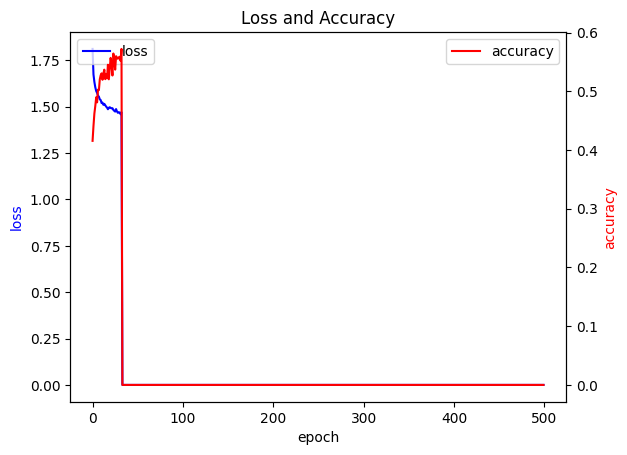

In [ ]:
print_output(loss, accuracy)

In [ ]:
print_output(loss2, accuracy2)

NameError: name 'loss2' is not defined

In [ ]:
def print_output(loss, accuracy):
  fig, ax1 = plt.subplots()

  # 绘制第一条线（主坐标轴）
  ax1.plot(loss, color='blue', label='loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss', color='blue')

  # 创建副坐标轴
  ax2 = ax1.twinx()

  # 绘制第二条线（副坐标轴）
  ax2.plot(accuracy, color='red', label='accuracy')
  ax2.set_ylabel('accuracy', color='red')

  # 添加标题和图例
  plt.title('Loss and Accuracy')
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  # 显示图表
  plt.show()